In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.layers.experimental.preprocessing \
  import Rescaling, RandomFlip, RandomRotation, RandomZoom

In [19]:
# Download dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [33]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'{image_count} samples')

3670 samples


# Create a dataset

In [21]:
batch_size = 32
img_height = 180
img_width = 180

In [22]:
# Extract train & test dataset 80:20 ratio
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [23]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Configure the dataset for performance

In [24]:
# Use cache & prefetching to improve the performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

In [26]:
# Augment the data with flip, rotation & zoom ops to create more
# but similar looking images from different angles.
# Helps reduce overfitting.
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", 
    input_shape=(img_height, 
                img_width,
                3)
    ),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

In [27]:
num_classes = 5
model = Sequential([
  data_augmentation,
  Rescaling(1./255),# Standardize the data using Min-Max scaling
  layers.Conv2D(16, 3, padding='same', activation='relu'), # 16 3x3 filters 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'), # 32 3x3 filters
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), # 64 3x3 filters
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Randomly drop node 20% of outputs to reduce overfitting
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # Output num_classes logits
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [30]:
# Note: Using GPU significantly improves fitting time
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs # No. of iterations
)

Epoch 1/15
92/92 [==============================] - 10s 58ms/step - loss: 1.3016 - accuracy: 0.4356 - val_loss: 1.0808 - val_accuracy: 0.5572
Epoch 2/15
92/92 [==============================] - 4s 45ms/step - loss: 1.0670 - accuracy: 0.5807 - val_loss: 0.9982 - val_accuracy: 0.6049
Epoch 3/15
92/92 [==============================] - 4s 45ms/step - loss: 0.9519 - accuracy: 0.6322 - val_loss: 0.9244 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 4s 45ms/step - loss: 0.8763 - accuracy: 0.6618 - val_loss: 0.9030 - val_accuracy: 0.6267
Epoch 5/15
92/92 [==============================] - 4s 45ms/step - loss: 0.8318 - accuracy: 0.6788 - val_loss: 0.8177 - val_accuracy: 0.6744
Epoch 6/15
92/92 [==============================] - 4s 45ms/step - loss: 0.7612 - accuracy: 0.7098 - val_loss: 0.8693 - val_accuracy: 0.6567
Epoch 7/15
92/92 [==============================] - 4s 45ms/step - loss: 0.7395 - accuracy: 0.7142 - val_loss: 0.8733 - val_accuracy: 0.6744
Epoch 8/15
9

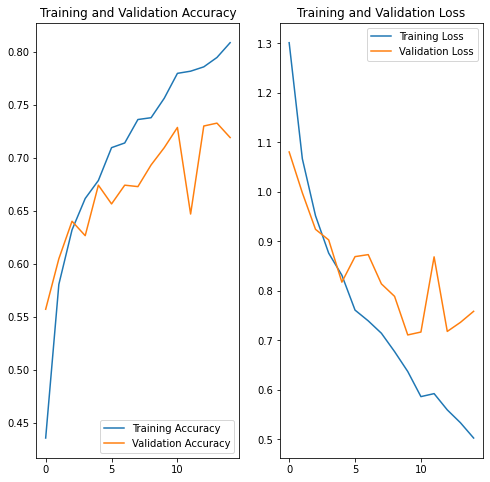

In [31]:
# Plot train & test accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

In [32]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Convert to batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0]) # Convert to probability

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.55 percent confidence.
